In [67]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import util


In [68]:
"""
Load frequency discrimination thresholds. This cell requires `eval.csv` files
in the model directories to re-calculate model thresholds or `results.csv` files
in the model directories to load previously calculated model thresholds.
"""

# list_dir_model = glob.glob("models/freq_all/IHC????/arch_*") # Models optimized for full frequency range
list_dir_model = glob.glob("models/freq_quarter_octave/*hz/IHC????/arch_*") # Models optimized separately for each quarter octave

# The `experiment` object generates `results.csv` files containing frequency discrimination
# thresholds in each model directory or loads them to a dataframe if they already exist
experiment = util.ExperimentHeinz2001FrequencyDiscrimination(overwrite=0, verbose=0)
df = experiment(list_dir_model)

def combine_dir_model(dir_model):
    """
    Assigns the same model directory to all frequency-specific models for plotting
    """
    dir_model = [_ for _ in dir_model.split("/") if ("hz" not in _) and ("arch" not in _)]
    dir_model = os.path.join(*dir_model)
    return dir_model

df_human = pd.read_csv("data/heinz_etal_2001_fig4a_frequency_discrimination_thresholds.csv")
df = pd.concat([df, df_human.rename(columns={"model": "dir_model"})])
df = df[df.f0 <= 8e3] # Exclude frequencies for which the model CF range influenced results (as in Heinz et al. 2001)
df["dir_model"] = df["dir_model"].map(combine_dir_model)
df = df.groupby(["dir_model", "f0"]).agg({"weber_fraction": list}).reset_index()
df


,dir_model,f0,weber_fraction
0,all_information_analytical,261.167077,[1.63e-05]
1,all_information_analytical,347.364553,[1.24e-05]
2,all_information_analytical,485.065743,[8.77e-06]
3,all_information_analytical,721.117512,[5.93e-06]
4,all_information_analytical,972.557770,[4.42e-06]
...,...,...,...
83,rate_place_computational,1963.592477,[0.001394372]
84,rate_place_computational,2919.152594,[0.0013061]
85,rate_place_computational,4048.095554,[0.001223415]
86,rate_place_computational,5613.642002,[0.001184057]


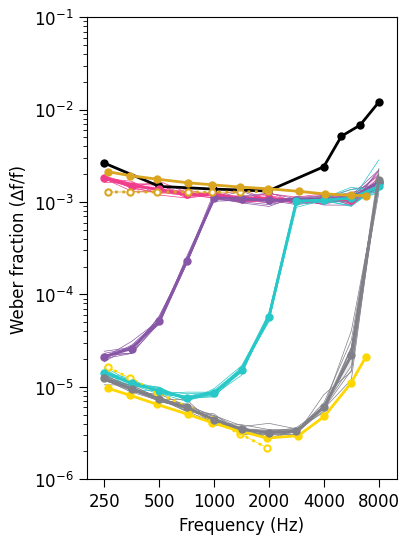

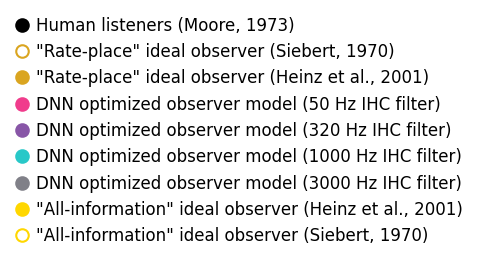

In [69]:
def get_color_and_label_from_dir_model(dir_model):
    """
    Specifies color and legend label for each model directory
    """
    if "human" in dir_model.lower():
        color = "k"
        label = "Human listeners (Moore, 1973)"
    elif "all_information_analytical" in dir_model.lower():
        color = "gold"
        label = '"All-information" ideal observer (Siebert, 1970)'
    elif "rate_place_analytical" in dir_model.lower():
        color = "goldenrod"
        label = '"Rate-place" ideal observer (Siebert, 1970)'
    elif "all_information_computational" in dir_model.lower():
        color = "gold"
        label = '"All-information" ideal observer (Heinz et al., 2001)'
    elif "rate_place_computational" in dir_model.lower():
        color = "goldenrod"
        label = '"Rate-place" ideal observer (Heinz et al., 2001)'
    elif "ihc3000" in dir_model.lower():
        color = "#808088"
        label = "DNN optimized observer model (3000 Hz IHC filter)"
    elif "ihc1000" in dir_model.lower():
        color = "#28C8C8"
        label = "DNN optimized observer model (1000 Hz IHC filter)"
    elif "ihc0320" in dir_model.lower():
        color = "#8856a7"
        label = "DNN optimized observer model (320 Hz IHC filter)"
    elif "ihc0050" in dir_model.lower():
        color = "#F03C8C"
        label = "DNN optimized observer model (50 Hz IHC filter)"
    else:
        color = None
        label = os.path.basename(os.path.dirname(dir_model))
    return color, label


fig, ax = plt.subplots(figsize=(4, 6))
legend_sort_values = []
for dir_model in sorted(df.dir_model.unique()):
    dfi = df[df.dir_model == dir_model]
    x = dfi.f0.values
    yarr = np.array(list(dfi.weber_fraction.values))
    log_yarr = np.log(yarr)
    log_yarr_mean = np.mean(log_yarr, axis=1)
    log_yarr_sem = np.std(log_yarr, axis=1) / np.sqrt(log_yarr.shape[1])
    y = np.exp(log_yarr_mean)
    legend_sort_values.append(y.min())
    color, label = get_color_and_label_from_dir_model(dir_model)
    kwargs_plot = {
        "marker":  "o",
        "ms": 4.5,
        "lw": 2,
        "mew": 1.5,
        "label": label,
        "color": color,
        "ls": ":" if "analytical" in dir_model else "-",
        "mfc": "w" if "analytical" in dir_model else None,
    }
    ax.fill_between(
        x,
        np.exp(log_yarr_mean - 2 * log_yarr_sem),
        np.exp(log_yarr_mean + 2 * log_yarr_sem),
        alpha=0.15,
        facecolor=kwargs_plot["color"],
    )
    ax.plot(x, y, **kwargs_plot)
    ax.plot(x, yarr, lw=0.5, color=kwargs_plot["color"], zorder=-1)
util.format_axes(
    ax,
    yscale="log",
    xscale="log",
    ylimits=[1e-6, 1e-1],
    xticks=[250, 500, 1000, 2000, 4000, 8000],
    xticks_minor=[],
    xticklabels=[250, 500, 1000, 2000, 4000, 8000],
    str_xlabel="Frequency (Hz)",
    str_ylabel="Weber fraction (∆f/f)",
    xlimits=[250 * 4/5, 8e3 * 5/4],
)
plt.show()


fig_legend, ax_legend = plt.subplots(figsize=(6, 3))
handles, labels = ax.get_legend_handles_labels()
idx_sort = np.argsort(legend_sort_values)[::-1]
kwargs_legend = {
    "fontsize": 12,
    "markerscale": 2,
    "handlelength": 0,
    "frameon": False,
    "loc": "center",
}
ax_legend.legend(
    [handles[_] for _ in idx_sort],
    [labels[_] for _ in idx_sort],
    **kwargs_legend,
)
util.format_axes(
    ax_legend,
    spines_to_hide=["top", "bottom", "left", "right"],
    xticks=[],
    yticks=[],
)
plt.show()


In [71]:
import json
import torch
import run_model
import util_torch
import pure_tone_dataset
import peripheral_model


dir_model = "models/freq_all/IHC3000/arch_0346_0000"

with open(os.path.join(dir_model, "config.json"), "r") as f:
    config_model = json.load(f)
with open(os.path.join(dir_model, "arch.json"), "r") as f:
    architecture = json.load(f)

model = run_model.Model(
    config_model=config_model,
    architecture=architecture,
)

util_torch.load_model_checkpoint(
    model.perceptual_model,
    dir_model,
    map_location=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
)
model


[load_model_checkpoint] models/freq_all/IHC3000/arch_0346_0000/ckpt_BEST.pt


Model(
  (peripheral_model): PeripheralModel(
    (gammatone_filterbank): GammatoneFilterbank(
      (fbs): ModuleList(
        (0-3): 4 x IIRFilterbank()
      )
    )
    (ihc_nonlinearity): IHCNonlinearity()
    (ihc_lowpassfilter): IHCLowpassFilter()
    (neural_adaptation): NeuralAdaptation()
  )
  (perceptual_model): PerceptualModel(
    (body): Sequential(
      (conv_0): CustomPaddedConv2d(2, 32, kernel_size=(3, 53), stride=(1, 1))
      (relu_0): ReLU()
      (pool_0): HanningPooling()
      (batch_norm_0): SyncBatchNorm(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_1): CustomPaddedConv2d(32, 64, kernel_size=(1, 60), stride=(1, 1))
      (relu_1): ReLU()
      (pool_1): HanningPooling()
      (batch_norm_1): SyncBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_2): CustomPaddedConv2d(64, 128, kernel_size=(3, 46), stride=(1, 1))
      (relu_2): ReLU()
      (pool_2): HanningPooling()
      (batch_norm_2):

In [74]:
dataset = pure_tone_dataset.Dataset()
example = dataset[0]
x = torch.stack([
    example["x0"],
    example["x1"],
])
model.eval()
model.peripheral_model(x[None, ...]).shape, model(x[None, ...])


(torch.Size([1, 2, 60, 5000]),
 {'label': tensor([[-8.4740]], grad_fn=<AddmmBackward0>)})